In [ ]:
!pip install yahoo-fin

In [ ]:
!pip install requests_html

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import yahoo_fin.stock_info as si
import datetime
from datetime import date
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from yahoo_fin import options

In [5]:
    BUFFER_SIZE = 10000
    BATCH_SIZE = 64
    tweetTexts = []

In [6]:
    dataSet, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
    train_dataSet, test_dataSet = dataSet['train'], dataSet['test']
    encoder = info.features['text'].encoder

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteS6GY2N/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteS6GY2N/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteS6GY2N/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
# Or load a previous model
model = keras.models.load_model("/content/RNN_2020-04-17.h5")

In [ ]:
padded_shapes = ([None], ())
train_dataSet = train_dataSet.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
test_dataSet = test_dataSet.padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)

In [ ]:
    model = tf.keras.Sequential([tf.keras.layers.Embedding(encoder.vocab_size, 64),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [ ]:
fit_model = model.fit(train_dataSet, epochs=5, validation_data=test_dataSet, validation_steps=30)

Epoch 1/5
391/391 [==============================] - 76s 194ms/step - loss: 0.6297 - accuracy: 0.6147 - val_loss: 0.4476 - val_accuracy: 0.8078
Epoch 2/5
391/391 [==============================] - 76s 194ms/step - loss: 0.3471 - accuracy: 0.8646 - val_loss: 0.3556 - val_accuracy: 0.8542
Epoch 3/5
391/391 [==============================] - 76s 194ms/step - loss: 0.2585 - accuracy: 0.9081 - val_loss: 0.3275 - val_accuracy: 0.8708
Epoch 4/5
391/391 [==============================] - 75s 192ms/step - loss: 0.2095 - accuracy: 0.9316 - val_loss: 0.3728 - val_accuracy: 0.8521
Epoch 5/5
391/391 [==============================] - 75s 192ms/step - loss: 0.1859 - accuracy: 0.9402 - val_loss: 0.3559 - val_accuracy: 0.8573


In [ ]:
today = date.today()
model.save('RNN_' + str(today) + '.h5')

In [8]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [9]:
def predict(post, pad):
  encoded_sample_pred_text = encoder.encode(post)
  if pad:
      encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return predictions

In [10]:
sample_text = ('This movie was awesome. The acting was incredible.')
prediction_ex = predict(sample_text, pad=True)
prediction_ex

array([[0.91235095]], dtype=float32)

In [11]:
sample_text_2 = ('This movie was so so. The acting was medicore.')
prediction_ex_2 = predict(sample_text_2, pad=True)
prediction_ex_2

array([[0.5152679]], dtype=float32)

In [12]:
sample_text_3 = ('This movie was wierd. The acting was annoying.')
prediction_ex_3 = predict(sample_text_3, pad=True)
prediction_ex_3

array([[0.33125502]], dtype=float32)

In [13]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tikcers = ['AMD', 'AMZN', 'FB', 'GOOG']

In [14]:
news_tables = {}

for ticker in company_tikcers:
  url = website_url + ticker

  req = Request(url=url, headers={'user-agent': 'my-scrape'})
  response = urlopen(req)
  html = BeautifulSoup(response, 'html')
  news_data = html.find(id='news-table')
  news_tables[ticker] = news_data

In [15]:
parsed_data = []

for ticker, news_table in news_tables.items():
  for row in news_table.findAll('tr'):
    title = row.a.text
    date_data = row.td.text.split(' ')

    if len(date_data) == 1:
      time = date_data[0][0:7]
    else:
      date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
      time = date_data[1][0:7]

    parsed_data.append([ticker, date, time, title])

In [16]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2020/11/17,06:30AM,"Intel May Be Down, But It's Far From Being Out"
1,AMD,2020/11/16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...
2,AMD,2020/11/16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...
3,AMD,2020/11/16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...
4,AMD,2020/11/16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage


In [17]:
dataset['Compound'] = dataset['News Headline'].apply(lambda headline: float(predict(headline, pad=True)))

In [18]:
dataset.head()

,Company,Date,Time,News Headline,Compound
0,AMD,2020/11/17,06:30AM,"Intel May Be Down, But It's Far From Being Out",0.419827
1,AMD,2020/11/16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.730233
2,AMD,2020/11/16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.119468
3,AMD,2020/11/16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.765284
4,AMD,2020/11/16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.245558


In [19]:
def sentiment_declareation(sentiment_value):
  if sentiment_value == 0.5:
      return 'neu'
  elif 0.5 < sentiment_value <= 1.0:
      return 'pos'
  elif 0.0 < sentiment_value <= 0.5:
      return 'neg'

In [20]:
dataset['Sentiment'] = dataset['Compound'].apply(lambda value: sentiment_declareation(value))

In [21]:
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date

In [22]:
dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",0.419827,neg
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.730233,pos
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.119468,neg
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.765284,pos
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.245558,neg


In [23]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

In [24]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2020-10-27  2020-11-17
AMZN     2020-11-12  2020-11-17
FB       2020-11-06  2020-11-17
GOOG     2020-11-10  2020-11-17

In [25]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",0.419827,neg,2020-11-17,2020-10-27
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.730233,pos,2020-11-17,2020-10-27
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.119468,neg,2020-11-17,2020-10-27
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.765284,pos,2020-11-17,2020-10-27
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.245558,neg,2020-11-17,2020-10-27


In [26]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2020, 10, 27),
  'late': datetime.date(2020, 11, 17)},
 'AMZN': {'early': datetime.date(2020, 11, 12),
  'late': datetime.date(2020, 11, 17)},
 'FB': {'early': datetime.date(2020, 11, 6),
  'late': datetime.date(2020, 11, 17)},
 'GOOG': {'early': datetime.date(2020, 11, 10),
  'late': datetime.date(2020, 11, 17)}}

In [27]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_RNN.csv', index=False)

AMD -> {'early': datetime.date(2020, 10, 27), 'late': datetime.date(2020, 11, 17)}
AMZN -> {'early': datetime.date(2020, 11, 12), 'late': datetime.date(2020, 11, 17)}
FB -> {'early': datetime.date(2020, 11, 6), 'late': datetime.date(2020, 11, 17)}
GOOG -> {'early': datetime.date(2020, 11, 10), 'late': datetime.date(2020, 11, 17)}


In [28]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 171, 'pos': 229}

In [29]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 50, 'neu': 0, 'pos': 49},
 'AMZN': {'neg': 39, 'neu': 0, 'pos': 60},
 'FB': {'neg': 35, 'neu': 0, 'pos': 64},
 'GOOG': {'neg': 45, 'neu': 0, 'pos': 54}}

In [30]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 50, 'neu': 0, 'pos': 49}
AMZN -> {'neg': 39, 'neu': 0, 'pos': 60}
FB -> {'neg': 35, 'neu': 0, 'pos': 64}
GOOG -> {'neg': 45, 'neu': 0, 'pos': 54}


,Company,Neg,Neu,Pos
0,AMD,50,0,49
1,AMZN,39,0,60
2,FB,35,0,64
3,GOOG,45,0,54


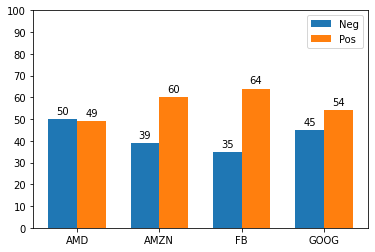

In [31]:
index = np.arange(len(company_tikcers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width/2, dataset_company['Neg'], bar_width, label='Neg')
barPos = ax.bar(index + bar_width/2, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tikcers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barPos)

plt.show()

In [32]:
mean_df = dataset.groupby(['Company', 'Date']).mean()

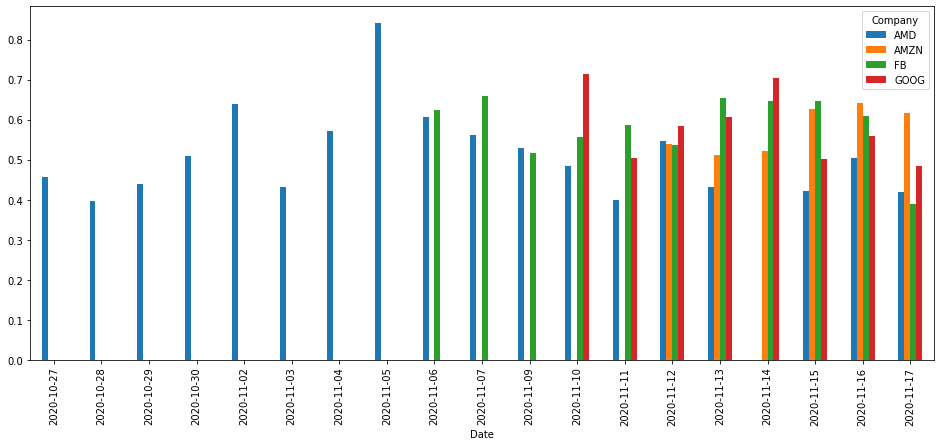

In [33]:
mean_df = mean_df.unstack()
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(16.2, 6.5))

In [34]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [35]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

In [36]:
def company_specific_sentiment_visualization(company_name):
  company_df = dataset[dataset['Company'] == company_name]
  temp = company_df.groupby(['Company', 'Date']).mean()
  temp= temp.unstack()
  temp = temp.xs('Compound', axis='columns').transpose()
  temp.plot(kind='line', figsize=(16.2, 6.5))

In [37]:
def company_specific_sentiment_and_stockclose_day_focus_visualization(company_name, company_stock_dataframe):
  company_specific = dataset[dataset['Company'] == company_name]
  temp_company = company_specific.groupby(['Company', 'Date']).mean()
  temp_company.to_csv(company_name + '_SentimentAndValueOnDays.csv')

  temp_dataframe = pd.read_csv("/content/" + company_name + "_SentimentAndValueOnDays.csv")
  temp_dataframe['adjclose'] = temp_dataframe.Date.map(company_stock_dataframe.set_index('date')['adjclose'].to_dict())
  temp_dataframe = temp_dataframe.dropna(subset=['adjclose'])
  return temp_dataframe

In [38]:
def company_compound_adjclose_normalized(company_name, company_combinated_dataframe):
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()

  plt.figure(figsize=(16.2, 6.5))
  plt.title(company_name + ': Normalized AdjClose values with Compounds')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['Compound'], label='compound')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['adjclose'], label='adjclose')
  plt.xticks(rotation=70)
  plt.xlabel('Date')
  plt.ylabel('Compound')
  plt.legend()
  plt.show()

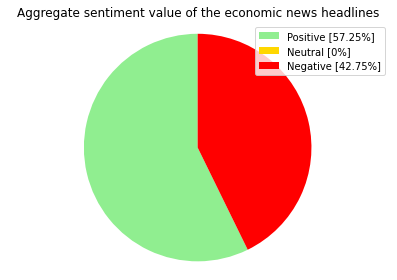

In [39]:
# össze gazdasági megítélés ezen cégek híreire fókuszálva
all_num = sentiment_result['pos'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=0, negative=neg_percent)

In [40]:
amd_stock = pd.read_csv("/content/AMD_RNN.csv")
amzn_stock = pd.read_csv("/content/AMZN_RNN.csv")
fb_stock = pd.read_csv("/content/FB_RNN.csv")
goog_stock = pd.read_csv("/content/GOOG_RNN.csv")

In [41]:
def company_corr(company_stock, company_combinated_dataframe):
  company_data = company_combinated_dataframe.merge(company_stock, on='adjclose')
  company_data.drop(['ticker', 'date'], axis=1, inplace=True)
  company_data.rename(columns = {'Compound_x':'Compound'}, inplace = True) 

  plt.figure(figsize=(16, 10))
  sns.heatmap(company_data[['open', 'low', 'high', 'adjclose', 'Compound', 'volume']].corr(), annot=True)
  plt.show()

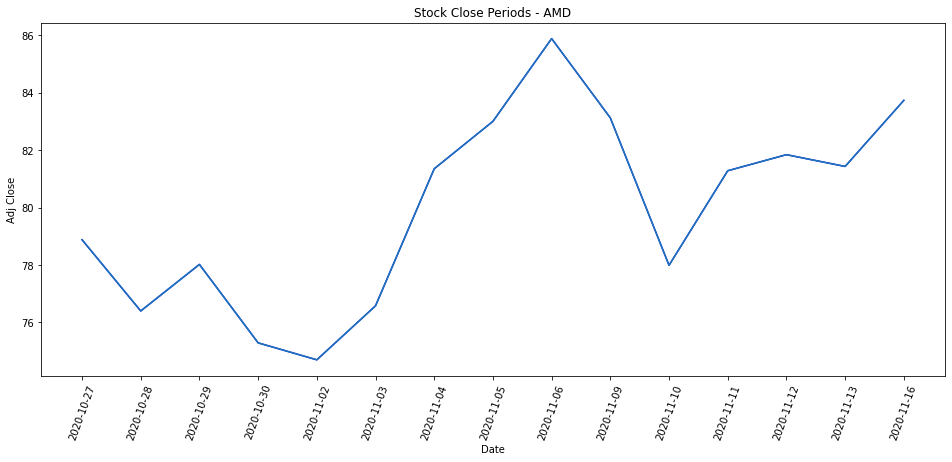

In [47]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMD')
plt.plot(amd_stock['adjclose'], label='AMD', color = 'blue')
x = amd_stock['date']
y = amd_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

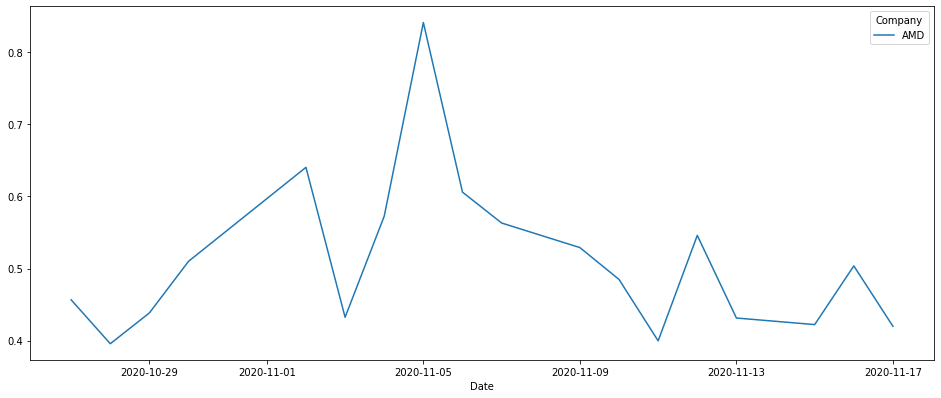

In [48]:
company_specific_sentiment_visualization('AMD')

In [49]:
AMD_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMD', amd_stock)
AMD_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,AMD,2020-10-27,0.456605,78.879997
1,AMD,2020-10-28,0.395689,76.400002
2,AMD,2020-10-29,0.438478,78.019997
3,AMD,2020-10-30,0.510014,75.290001
4,AMD,2020-11-02,0.640282,74.699997


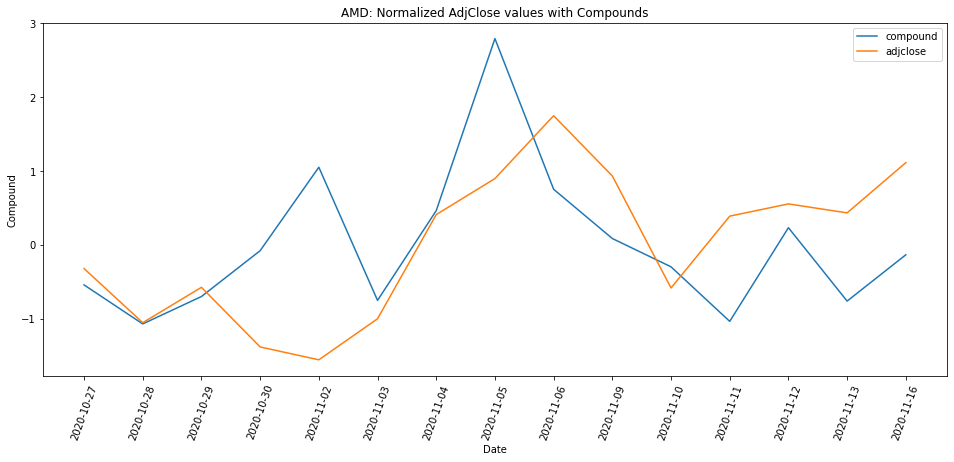

In [50]:
company_compound_adjclose_normalized('AMD', AMD_combinated_dataframe)

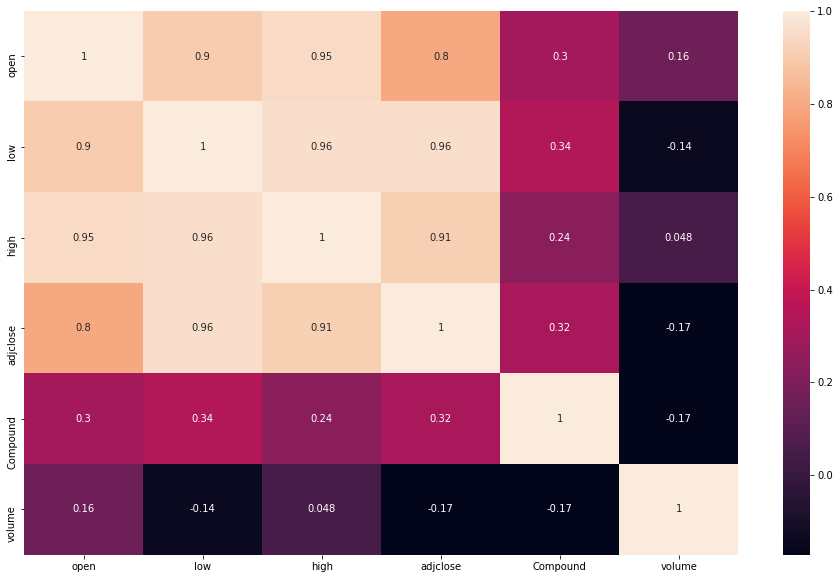

In [51]:
company_corr(amd_stock, AMD_combinated_dataframe)

In [52]:
pd.options.display.float_format = '{:,.3f}'.format
amd_stock.corr()

,open,high,low,close,adjclose,volume
open,1.000,0.946,0.902,0.800,0.800,0.159
high,0.946,1.000,0.962,0.911,0.911,0.048
low,0.902,0.962,1.000,0.963,0.963,-0.140
close,0.800,0.911,0.963,1.000,1.000,-0.172
adjclose,0.800,0.911,0.963,1.000,1.000,-0.172
volume,0.159,0.048,-0.140,-0.172,-0.172,1.000


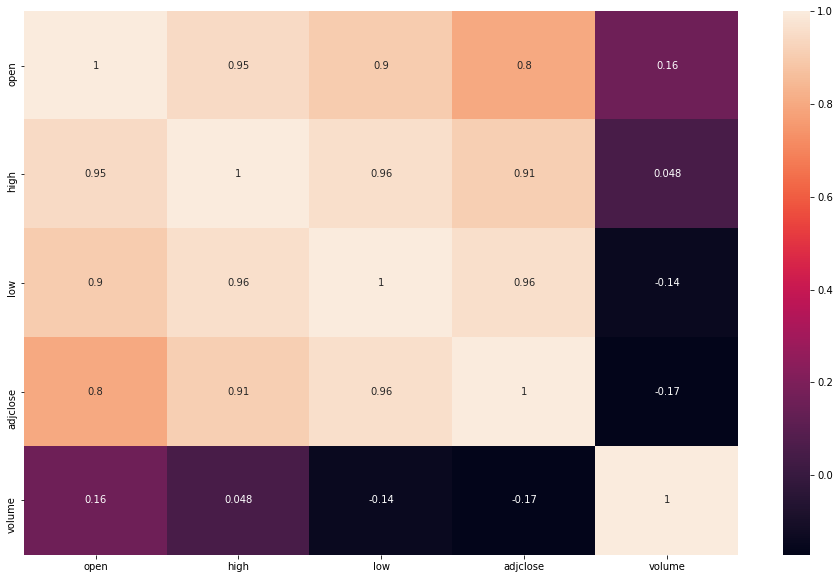

In [53]:
# amd stock correlation analisys

plt.figure(figsize=(16, 10))
sns.heatmap(amd_stock[['open', 'high', 'low', 'adjclose', 'volume']].corr(), annot=True)
plt.show()

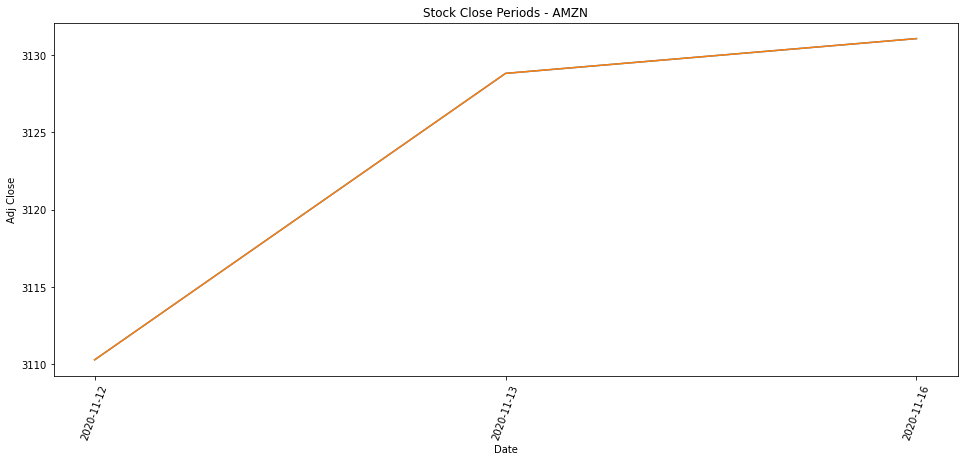

In [54]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMZN')
plt.plot(amzn_stock['adjclose'])
x = amzn_stock['date']
y = amzn_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

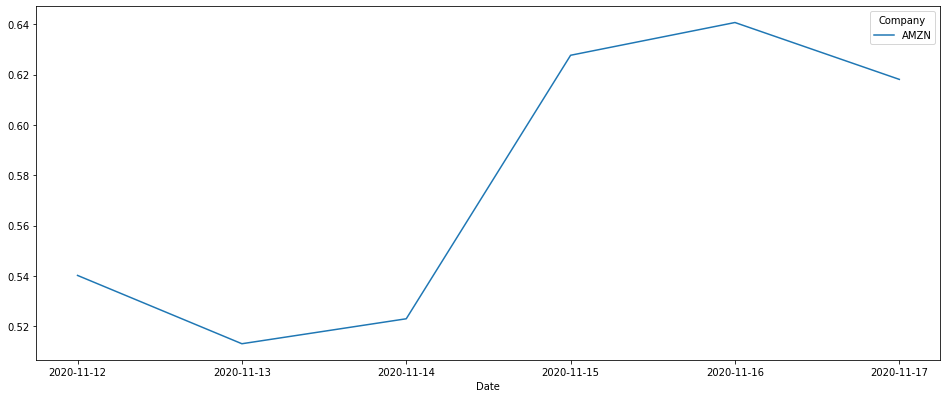

In [55]:
company_specific_sentiment_visualization('AMZN')

In [56]:
AMZN_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMZN', amzn_stock)
AMZN_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,AMZN,2020-11-12,0.540,"3,110.280"
1,AMZN,2020-11-13,0.513,"3,128.810"
4,AMZN,2020-11-16,0.641,"3,131.060"


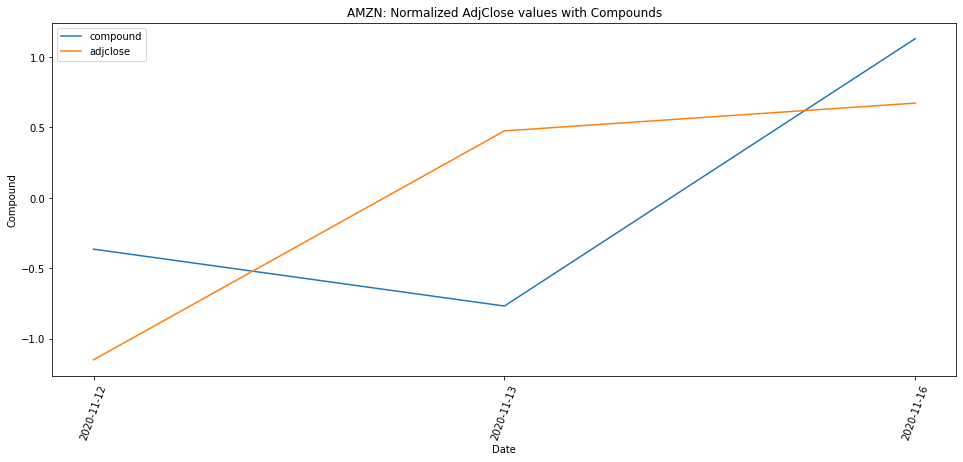

In [57]:
company_compound_adjclose_normalized('AMZN', AMZN_combinated_dataframe)

In [ ]:
company_corr(amzn_stock, AMZN_combinated_dataframe)

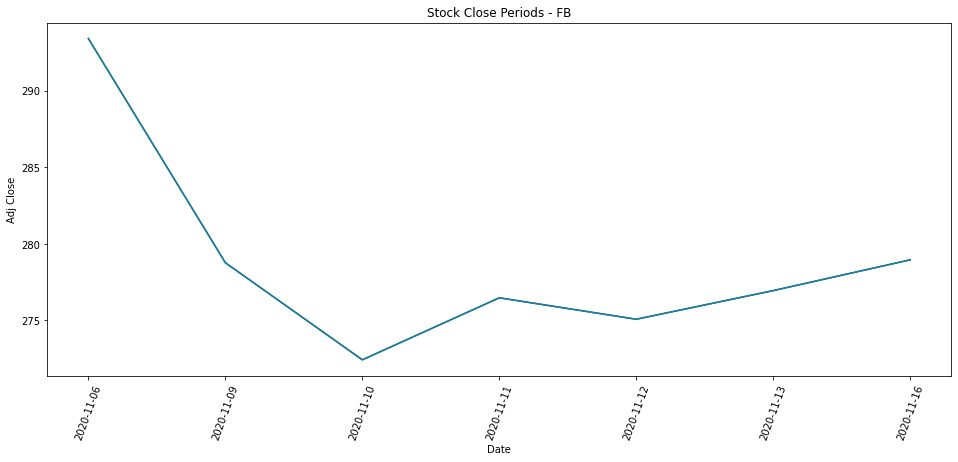

In [60]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - FB')
plt.plot(fb_stock['adjclose'], label='FB', color = 'green')
x = fb_stock['date']
y = fb_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

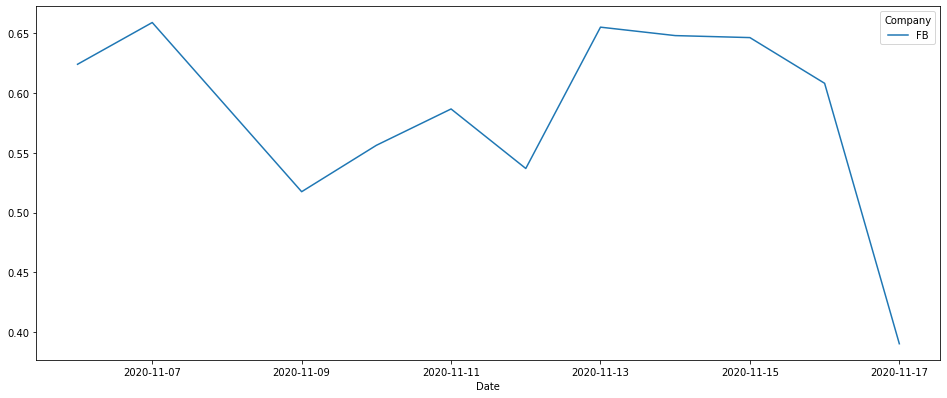

In [61]:
company_specific_sentiment_visualization('FB')

In [62]:
FB_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('FB', fb_stock)
FB_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,FB,2020-11-06,0.624,293.410
2,FB,2020-11-09,0.517,278.770
3,FB,2020-11-10,0.556,272.430
4,FB,2020-11-11,0.587,276.480
5,FB,2020-11-12,0.537,275.080


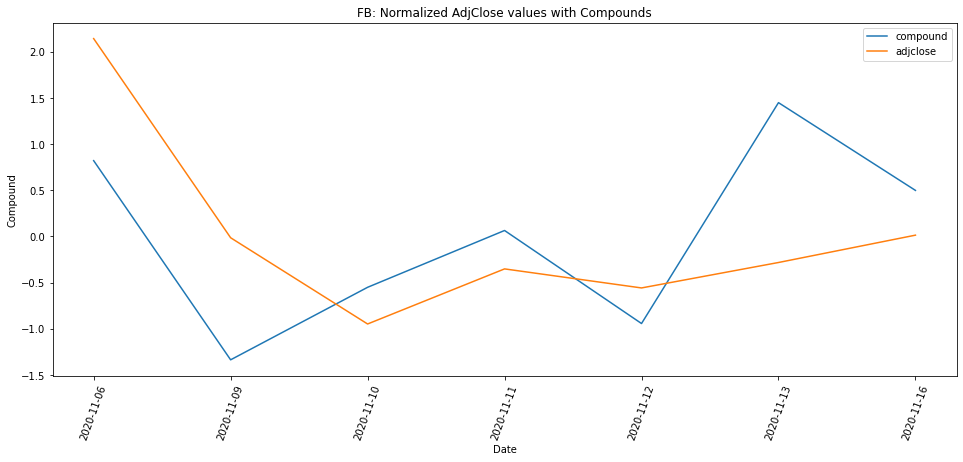

In [63]:
company_compound_adjclose_normalized('FB', FB_combinated_dataframe)

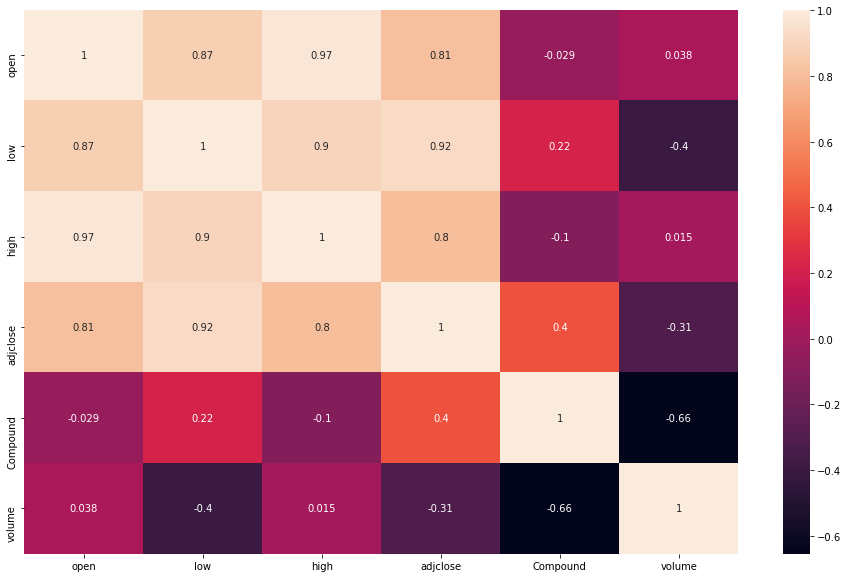

In [64]:
company_corr(fb_stock, FB_combinated_dataframe)

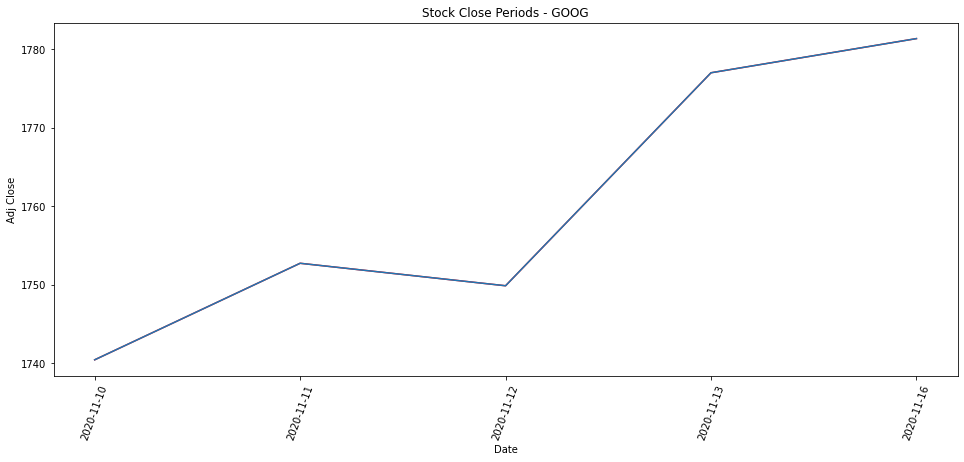

In [65]:
plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - GOOG')
plt.plot(goog_stock['adjclose'], label='GOOG', color = 'red')
x = goog_stock['date']
y = goog_stock['adjclose']
plt.plot(x, y)
plt.xticks(rotation=70)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()

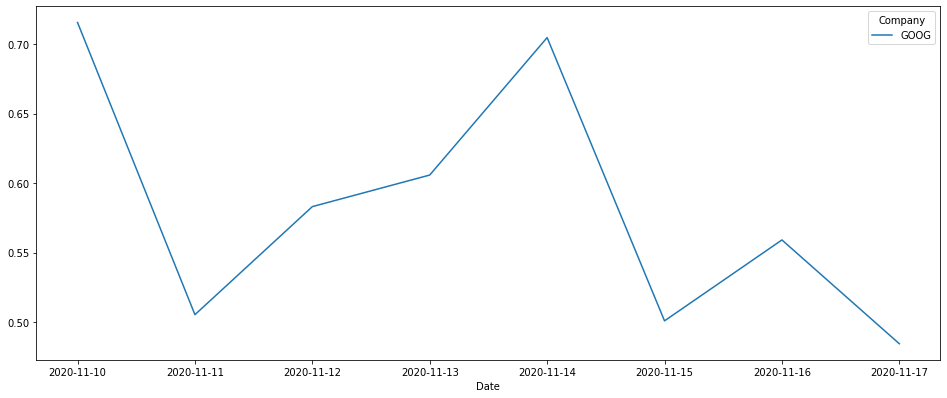

In [66]:
company_specific_sentiment_visualization('GOOG')

In [67]:
GOOG_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('GOOG', goog_stock)
GOOG_combinated_dataframe.head()

,Company,Date,Compound,adjclose
0,GOOG,2020-11-10,0.715,"1,740.390"
1,GOOG,2020-11-11,0.505,"1,752.710"
2,GOOG,2020-11-12,0.583,"1,749.840"
3,GOOG,2020-11-13,0.606,"1,777.020"
6,GOOG,2020-11-16,0.559,"1,781.380"


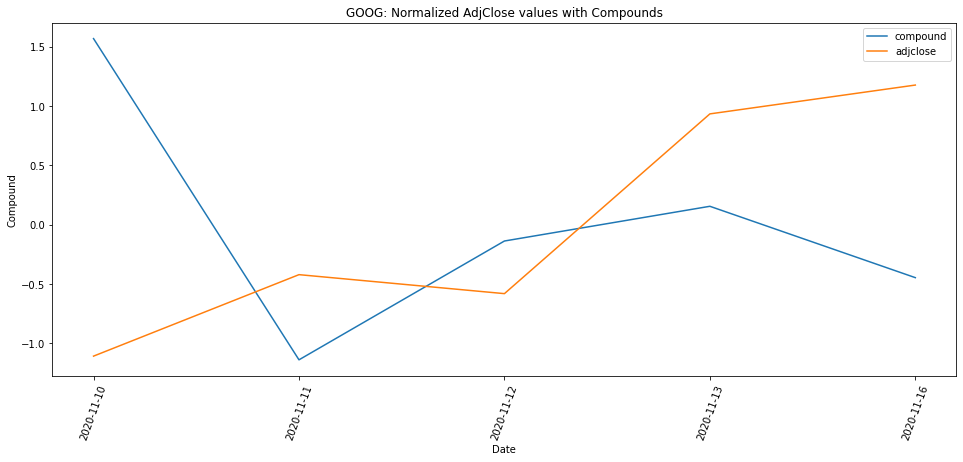

In [68]:
company_compound_adjclose_normalized('GOOG', GOOG_combinated_dataframe)

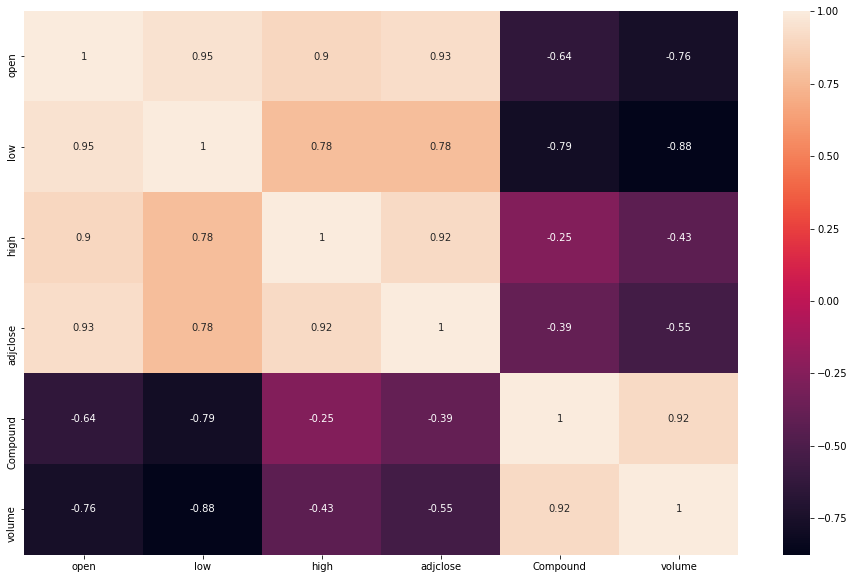

In [69]:
company_corr(goog_stock, GOOG_combinated_dataframe)